# ISLR - Python Ch8 Applied 12

- [Import Boston Housing Dataset](#Import-Boston-Housing-Dataset)
- [Build and Validate a Bagging Model](#Build-and-Validate-a-Bagging-Model)
- [Build and Validate a Random Forest Model](#Build-and-Validate-a-Random-Forest-Model)
- [Build and Validate a Boosting Model](#Build-and-Validate-a-Boosting-Model)
- [Compare Results with a Linear Model](#Compare-Results-with-a-Linear-Model)

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV, Lasso
from sklearn.cross_validation import cross_val_score


%matplotlib inline
plt.style.use('ggplot')

## Import Boston Housing Dataset

In [4]:
boston = pd.read_csv('../../../data/Boston.csv', index_col=0)

In [11]:
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [17]:
# Lets define the predictors and the response. Here we will try to predict 
# the medv response variable from all the other variable in the dataframe
predictors = boston.columns.tolist()
predictors.remove('medv')
X = boston[predictors].values
y = boston['medv'].values
# notice here I have not split the dataset. Lets use cross-validation instead since most
# of the problems in the applied section have used the validation set approach

## Build and Validate a Bagging Model

In [34]:
# The only parameter to determine for the bagging model is the number of trees. We 
# determine this using the oob_score_, a measure of the test error rate of the model.
score = []
for num_trees in range(100,600):
    # build and fit our bagger
    bagger = RandomForestRegressor(n_estimators=num_trees, oob_score=True, random_state=0)
    bagger.fit(X,y)
    # append the baggers score
    score.append(bagger.oob_score_)

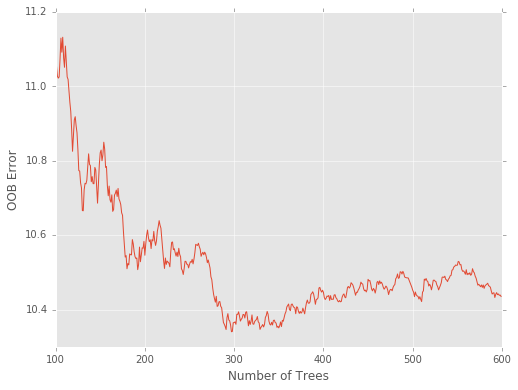

In [36]:
# In sklearn, the oob_score_ is R^2 so we need to convert R^2 to MSE to compatible with
# the ISLR book. Recall that R^2 = 1-RSS/TSS = 1-(RSS/n)/(TSS/n) = 1-MSE/var(y).
var_y = np.var(y)
bagging_mse = [(1-el)*var_y for el in score]
# Plot the MSE
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(range(100,600), bagging_mse);
ax.set_xlabel('Number of Trees');
ax.set_ylabel('OOB Error');

So for ~500 trees the Test MSE begins to settle down. Lets build the final model and compute the oob_score_ for a 500 tree Bagging Model.

In [40]:
bagger = RandomForestRegressor(n_estimators=500, oob_score=True, 
                                        random_state=0).fit(X,y)
print('Bagging Model Test MSE = ', (1-bagger.oob_score_)*var_y)

Bagging Model Test MSE =  10.4521078816


## Build and Validate a Random Forest Model

In [42]:
# Build a random forest using 500 trees (determined from the bagging model). We will 
# use the sqrt sample of the predictors
forest = RandomForestRegressor(n_estimators=500, max_features='sqrt', 
                               oob_score=True).fit(X,y)
print('Random Forest Model Test MSE = ', (1-forest.oob_score_)*var_y)

Random Forest Model Test MSE =  9.77564640868


So the Random Forest improves slightly, though we would need to do a statistical test to see if the difference is significant.

## Build and Validate a Boosting Model

In [45]:
# For boosting models the number of trees, the depth and the learning rate need to be 
# optimized. Here we will vary just the learning rate and then the number of trees. 

booster_scores = []
learn_rates = np.linspace(0.001,.1, 100)

for rate in learn_rates:
    # make a boosting model
    booster = GradientBoostingRegressor(learning_rate=rate, n_estimators=500, max_depth=3, 
                                        random_state=0)
    # compute the test MSE of the model using cross-validation
    score = -np.mean(cross_val_score(booster, X,y, scoring='mean_squared_error', cv=10))
    booster_scores.append(score)

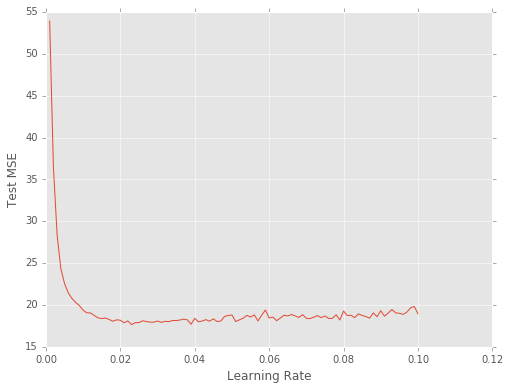

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(learn_rates, booster_scores);
ax.set_xlabel('Learning Rate');
ax.set_ylabel('Test MSE');

So the Test MSE looks pretty stable over a range of learning rates. Lets choose a 0.06 rate. Now lets vary the number of trees.

In [54]:
booster_scores = []
num_trees = np.linspace(50,1500,30)

for num_tree in num_trees:
    # make a boosting model
    booster = GradientBoostingRegressor(learning_rate=0.06, n_estimators=int(num_tree), 
                                        max_depth=3, random_state=0)
    # compute the test MSE of the model using cross-validation
    score = -np.mean(cross_val_score(booster, X,y, scoring='mean_squared_error', cv=10))
    booster_scores.append(score)

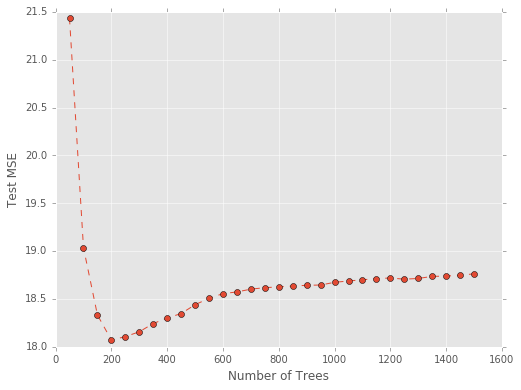

In [55]:
# plot the Test MSE against the number of trees
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(num_trees, booster_scores, marker='o', linestyle='--');
ax.set_xlabel('Number of Trees');
ax.set_ylabel('Test MSE');

The Test MSE stabilizes near 1000 trees. Lets now build the final model using a learning rate of 0.06 and 1000 trees and get the Test CV error.

In [60]:
# Build the boosting model with the optimized parameters determined above.
boosting_model = GradientBoostingRegressor(learning_rate=0.06, n_estimators=1000, 
                                        max_depth=3, random_state=0)

# compute the test MSE of the model using cross-validation
score = -np.mean(cross_val_score(boosting_model, X,y, scoring='mean_squared_error', 
                                    cv=len(boston)))
    
print('Boosting Model Test Error = ', score)

Boosting Model Test Error =  8.36696932869


Notice in the above I used LOOCV to get the Test Error rate. I did this because we want to compare with the bagging and Random Forest models. In those models we used the OOB score which for large number of trees is equivalent to the LOOCV. So the boosting model slightly outperforms both the Bagging and Random Forest approaches. Now lets take a look at a linear model.

## Build a Regularized Linear Model

In [70]:
# Fit a lasso model and use cross-validation to determine the optimal alpha penaliztion
Lasso_est = LassoCV(normalize=True, cv=10).fit(X,y)

In [69]:
Lasso_est.alpha_

0.0085812304989614403

In [73]:
# Compute the LOOCV error of the Lasso regularized model
lasso_est = Lasso(alpha=Lasso_est.alpha_, normalize=True, random_state=0)
lasso_mse = -np.mean(cross_val_score(lasso_est, X, y, scoring='mean_squared_error',
                                     cv=len(boston)))
                     
print('Lasso Test MSE = ', lasso_mse)

Lasso Test MSE =  25.226293062


Clearly the Lasso method is being outperformed by the tree methods. Based on previous findings with this dataset this is not too suprising for example we have already observed non-linearities between the predictors and the response. For example the plot below shows a non-linear relationship between the 'lstat' feature and the medv response.

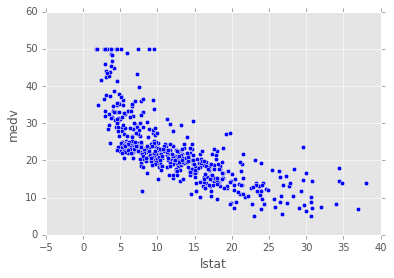

In [74]:
plt.scatter(boston.lstat, boston.medv, marker='o');
plt.xlabel('lstat');
plt.ylabel('medv');

Non-Linearities allow for the tree methods to significantly outperform the best multiple linear regression models. 